In [1]:
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import time
import PIL

In [2]:
class HWDataset(Dataset):
    def __init__(self,data_dir):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((48, 48)),
            transforms.ToTensor()
        ])        
        self.train_set = datasets.ImageFolder(data_dir+'/train',self.transform)
        self.test_set = datasets.ImageFolder(data_dir+'/test',self.transform)
    
    def get_dataloader(self,batch_size):
        train_loader = DataLoader(self.train_set,batch_size=batch_size,shuffle=True)
        test_loader = DataLoader(self.test_set,batch_size=batch_size,shuffle=False)
        return train_loader,test_loader
    

In [3]:
ds = HWDataset(data_dir='../data')

In [4]:
trn_set = ds.train_set

In [5]:
for x in trn_set:
    print(x[0][0].shape)
    break

torch.Size([48, 48])


In [6]:
import sys
sys.path.append('../tools/')
from net import HWNet

In [7]:
device = torch.device("cuda")

In [8]:
def train(net,data_loader,loss_fn,optimizer,device):
    size = len(data_loader.dataset)
    net.train()
    for batch,(X,y) in enumerate(data_loader):
        optimizer.zero_grad()    
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat,y)
        loss.backward()
        optimizer.step()

        if batch%2==0:
            loss = loss.item()
            current_batch = (batch+1)*len(X)
            print(f' loss:{loss:>.5f},[{current_batch:>5d}/{size:>5d}]',end='\r')
    print(f"Already trained an epoch,waiting for validate ...")

In [9]:
trn_loader,tst_loader = ds.get_dataloader(batch_size=256)

In [54]:
len(trn_set.classes)

3755

In [10]:
net = HWNet(len(trn_set.classes))

In [11]:
# for x,y in trn_loader:
#     print(x.shape)
#     y_hat = net(x)
#     print(y_hat)
#     print(y)
#     print((y == y_hat.argmax(1)))
#     break

torch.Size([32, 1, 48, 48])
tensor([[-0.0881,  0.1481,  0.2420,  0.4198, -0.0890,  0.0564, -0.2304,  0.4355],
        [-0.1424, -0.1475,  0.0141, -0.1214,  0.0094,  0.1346, -0.1565, -0.0375],
        [ 0.0849, -0.0825, -0.0600, -0.2843, -0.0967,  0.0114, -0.2994,  0.0253],
        [ 0.0670, -0.0602,  0.1788, -0.1134,  0.1122, -0.3295,  0.0879,  0.0871],
        [ 0.2676,  0.1185,  0.0719, -0.0580, -0.4283,  0.4847, -0.0366,  0.2121],
        [ 0.1478,  0.0101, -0.0396, -0.1400, -0.1984, -0.2473,  0.1640,  0.0503],
        [-0.2499,  0.2351,  0.0732, -0.0151, -0.1005,  0.0228, -0.1766, -0.0426],
        [-0.0203,  0.6899,  0.2534, -0.2278, -0.2145, -0.0024,  0.1197, -0.2385],
        [-0.1536,  0.0888, -0.3034,  0.2416,  0.1592,  0.1941, -0.8751,  0.2443],
        [-0.3165, -0.0939,  0.1146, -0.0323, -0.2501,  0.5295,  0.1459, -0.4211],
        [-0.5729,  0.1954,  0.5745, -0.6465, -0.2000,  0.1939,  0.6534, -0.1161],
        [ 0.2221,  0.2347, -0.1735, -0.2607,  0.4540,  0.0575,  0.6059

In [11]:
def test(net,data_loader,loss_fn,device):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    net.eval()
    correct,test_loss = 0,0
    with torch.no_grad():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_hat = net(X)
            test_loss += loss_fn(y_hat,y).item()
            correct += (y==y_hat.argmax(1)).float().sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test error:\n accuracy: {(100*correct):0.1f}%, avg loss: {test_loss:.5f}")

In [12]:
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.015)


In [13]:
epochs = 12
for t in range(epochs):
    print(f"Epoch {t+1}")
    start = time.time()
    train(net,trn_loader , loss_fn, optimizer,device)
    test(net,tst_loader, loss_fn,device)
    torch.save(net.state_dict(), 'handwriting.params')
    end = time.time()
    interval = (end-start)
    print(f"Time : {interval:.3f}s\n-------------------------------")
print('***End of train***')


Epoch 1
Already trained an epoch,waiting for validate ...
Test error:
 accuracy: 0.6%, avg loss: 7.69670
Time : 1156.178s
-------------------------------
Epoch 2
Already trained an epoch,waiting for validate ...
Test error:
 accuracy: 55.8%, avg loss: 2.07498
Time : 1112.404s
-------------------------------
Epoch 3
Already trained an epoch,waiting for validate ...
Test error:
 accuracy: 79.8%, avg loss: 0.86634
Time : 1104.083s
-------------------------------
Epoch 4
Already trained an epoch,waiting for validate ...
Test error:
 accuracy: 85.0%, avg loss: 0.61849
Time : 1118.477s
-------------------------------
Epoch 5
Already trained an epoch,waiting for validate ...
Test error:
 accuracy: 87.3%, avg loss: 0.51249
Time : 1284.478s
-------------------------------
Epoch 6
Already trained an epoch,waiting for validate ...
Test error:
 accuracy: 88.6%, avg loss: 0.45612
Time : 1256.760s
-------------------------------
Epoch 7
Already trained an epoch,waiting for validate ...
Test error:
 

In [14]:
transform = ds.transform

In [30]:
img = PIL.Image.open('../data/test/乘/21.jpg')
feature = transform(img)

In [31]:
feature.shape

torch.Size([1, 48, 48])

In [32]:
net = net.to('cpu')

In [33]:
feature = feature.reshape([1,1,48,48])
feature.shape

torch.Size([1, 1, 48, 48])

In [34]:
net(feature)

tensor([[-1.5222, -3.6178, -4.1880,  ..., -4.5380,  4.6413,  2.5261]],
       grad_fn=<AddmmBackward0>)

In [35]:
trn_set.classes[net(feature).argmax(1)]

'乘'

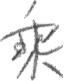

In [36]:
img

In [37]:
torch.save(net.state_dict(), 'final.pt')

In [51]:
res_k3 = [x.item() for x in list(torch.topk(net(feature),3).indices[0])]

In [53]:
for i in res_k3:
    print(trn_set.classes[i])

乘
乖
秉


In [56]:
hw_classes = trn_set.classes

In [57]:
import json

with open('hw.json', 'w') as file:
    json.dump(hw_classes, file)

In [58]:
with open('hw.json', 'r') as file:
    loaded_array = json.load(file)

print(loaded_array)

['一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丑', '专', '且', '世', '丘', '丙', '业', '丛', '东', '丝', '丢', '两', '严', '丧', '个', '丫', '中', '丰', '串', '临', '丸', '丹', '为', '主', '丽', '举', '乃', '久', '么', '义', '之', '乌', '乍', '乎', '乏', '乐', '乒', '乓', '乔', '乖', '乘', '乙', '九', '乞', '也', '习', '乡', '书', '买', '乱', '乳', '乾', '了', '予', '争', '事', '二', '于', '亏', '云', '互', '五', '井', '亚', '些', '亡', '亢', '交', '亥', '亦', '产', '亨', '亩', '享', '京', '亭', '亮', '亲', '人', '亿', '什', '仁', '仅', '仆', '仇', '今', '介', '仍', '从', '仑', '仓', '仔', '仕', '他', '仗', '付', '仙', '仟', '代', '令', '以', '仪', '们', '仰', '仲', '件', '价', '任', '份', '仿', '企', '伊', '伍', '伎', '伏', '伐', '休', '众', '优', '伙', '会', '伞', '伟', '传', '伤', '伦', '伪', '伯', '估', '伴', '伶', '伸', '伺', '似', '佃', '但', '位', '低', '住', '佐', '佑', '体', '何', '余', '佛', '作', '你', '佣', '佩', '佬', '佯', '佰', '佳', '使', '侄', '侈', '例', '侍', '侗', '供', '依', '侠', '侣', '侥', '侦', '侧', '侨', '侩', '侮', '侯', '侵', '便', '促', '俄', '俊', '俏', '俐', '俗', '俘', '保', '俞', '信', '俩', '俭', '修', '俯', '俱', '俺', '倍', '倒',

In [59]:
for i in res_k3:
    print(loaded_array[i])

乘
乖
秉


In [60]:
hw_classes

['一',
 '丁',
 '七',
 '万',
 '丈',
 '三',
 '上',
 '下',
 '不',
 '与',
 '丑',
 '专',
 '且',
 '世',
 '丘',
 '丙',
 '业',
 '丛',
 '东',
 '丝',
 '丢',
 '两',
 '严',
 '丧',
 '个',
 '丫',
 '中',
 '丰',
 '串',
 '临',
 '丸',
 '丹',
 '为',
 '主',
 '丽',
 '举',
 '乃',
 '久',
 '么',
 '义',
 '之',
 '乌',
 '乍',
 '乎',
 '乏',
 '乐',
 '乒',
 '乓',
 '乔',
 '乖',
 '乘',
 '乙',
 '九',
 '乞',
 '也',
 '习',
 '乡',
 '书',
 '买',
 '乱',
 '乳',
 '乾',
 '了',
 '予',
 '争',
 '事',
 '二',
 '于',
 '亏',
 '云',
 '互',
 '五',
 '井',
 '亚',
 '些',
 '亡',
 '亢',
 '交',
 '亥',
 '亦',
 '产',
 '亨',
 '亩',
 '享',
 '京',
 '亭',
 '亮',
 '亲',
 '人',
 '亿',
 '什',
 '仁',
 '仅',
 '仆',
 '仇',
 '今',
 '介',
 '仍',
 '从',
 '仑',
 '仓',
 '仔',
 '仕',
 '他',
 '仗',
 '付',
 '仙',
 '仟',
 '代',
 '令',
 '以',
 '仪',
 '们',
 '仰',
 '仲',
 '件',
 '价',
 '任',
 '份',
 '仿',
 '企',
 '伊',
 '伍',
 '伎',
 '伏',
 '伐',
 '休',
 '众',
 '优',
 '伙',
 '会',
 '伞',
 '伟',
 '传',
 '伤',
 '伦',
 '伪',
 '伯',
 '估',
 '伴',
 '伶',
 '伸',
 '伺',
 '似',
 '佃',
 '但',
 '位',
 '低',
 '住',
 '佐',
 '佑',
 '体',
 '何',
 '余',
 '佛',
 '作',
 '你',
 '佣',
 '佩',
 '佬',
 '佯',
 '佰',
 '佳',
 '使',
 '侄',
 '侈',
 '例'

In [61]:
new_net = HWNet(3755)

In [62]:
new_net.load_state_dict(torch.load('./handwriting.params'))

<All keys matched successfully>

In [63]:
trn_set.classes[new_net(feature).argmax(1)]

'聪'

In [64]:
torch.save(net,'handwriting_rec.pth')

In [65]:
new_net2 = torch.load('./handwriting_rec.pth')

In [66]:
trn_set.classes[new_net2(feature).argmax(1)]

'乘'